# sklearn应用之员工离职预测

本文的目的是利用DataCastle中的[员工离职训练赛](http://www.dcjingsai.com/common/cmpt/%E5%91%98%E5%B7%A5%E7%A6%BB%E8%81%8C%E9%A2%84%E6%B5%8B%E8%AE%AD%E7%BB%83%E8%B5%9B_%E7%AB%9E%E8%B5%9B%E4%BF%A1%E6%81%AF.html)，练习sklearn的应用，包括特征工程，模型训练和模型评估。旨在熟悉各种特征工程，指标，集成学习等API的使用，不考虑最终得分。

In [50]:
#pandas, numpy, matplotlib, seaborn
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
try:
    from jupyterthemes import jtplot
    jtplot.style(theme='onedork')
except ModuleNotFoundError:
    pass
import numpy as np
import time
%pylab inline

Populating the interactive namespace from numpy and matplotlib


C:\Anaconda3\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['clf']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [108]:
#sklearn API
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import learning_curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import BaggingClassifier

In [3]:
df_train = pd.read_csv('pfm_train.csv')
df_test = pd.read_csv('pfm_test.csv')

In [4]:
df_train.shape,df_test.shape

((1100, 31), (350, 30))

训练集有1100条数据，31个变量。测试集350条数据，30个变量，缺少的一个变量就是需要预测的员工离职状态。

In [5]:
df_train.info()
print('=*60')
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1100 entries, 0 to 1099
Data columns (total 31 columns):
Age                         1100 non-null int64
Attrition                   1100 non-null int64
BusinessTravel              1100 non-null object
Department                  1100 non-null object
DistanceFromHome            1100 non-null int64
Education                   1100 non-null int64
EducationField              1100 non-null object
EmployeeNumber              1100 non-null int64
EnvironmentSatisfaction     1100 non-null int64
Gender                      1100 non-null object
JobInvolvement              1100 non-null int64
JobLevel                    1100 non-null int64
JobRole                     1100 non-null object
JobSatisfaction             1100 non-null int64
MaritalStatus               1100 non-null object
MonthlyIncome               1100 non-null int64
NumCompaniesWorked          1100 non-null int64
Over18                      1100 non-null object
OverTime              

两个数据集都和完整，没有缺失值，有分类变量和数值变量。但从数据字典里分析得到，很多特征是序数，不能当作连续值看待。

In [6]:
pd.DataFrame({'train': df_train.apply(lambda x: len(x.unique())).astype(int32),
              'test': df_test.apply(lambda x: len(x.unique()))})

,test,train
Age,42.0,43
Attrition,NaN,2
BusinessTravel,3.0,3
Department,3.0,3
DistanceFromHome,29.0,29
Education,5.0,5
EducationField,6.0,6
EmployeeNumber,350.0,1100
EnvironmentSatisfaction,4.0,4
Gender,2.0,2


从各个特征的唯一值中可以看出，‘EmployeeNumber’是员工唯一的编号，‘Over18’表示所有的员工都超过了18岁，‘StandardHours’表示所有的员工标准工作时间都是相同的。这三个变量对分析没有意义，需要删除。但‘EmployeeNumber’作为员工唯一编号，对分析有好处，暂时保留。

In [7]:
#删除Over18和StandarHours两个特征
df_train.drop(['Over18','StandardHours'],axis=1,inplace=True)
df_test.drop(['Over18','StandardHours'],axis=1,inplace=True)

In [8]:
df_train.describe()

,Age,Attrition,DistanceFromHome,Education,EmployeeNumber,EnvironmentSatisfaction,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,...,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
count,1100.000000,1100.000000,1100.000000,1100.000000,1100.000000,1100.000000,1100.000000,1100.000000,1100.000000,1100.000000,...,1100.000000,1100.000000,1100.000000,1100.000000,1100.000000,1100.000000,1100.000000,1100.000000,1100.000000,1100.000000
mean,36.999091,0.161818,9.427273,2.922727,1028.157273,2.725455,2.730909,2.054545,2.732727,6483.620909,...,3.152727,2.696364,0.788182,11.221818,2.807273,2.746364,7.011818,4.207273,2.226364,4.123636
std,9.037230,0.368451,8.196694,1.022242,598.915204,1.098053,0.706366,1.107805,1.109731,4715.293419,...,0.359888,1.095356,0.843347,7.825548,1.291514,0.701121,6.223093,3.618115,3.313830,3.597996
min,18.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1009.000000,...,3.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,30.000000,0.000000,2.000000,2.000000,504.250000,2.000000,2.000000,1.000000,2.000000,2924.500000,...,3.000000,2.000000,0.000000,6.000000,2.000000,2.000000,3.000000,2.000000,0.000000,2.000000
50%,36.000000,0.000000,7.000000,3.000000,1026.500000,3.000000,3.000000,2.000000,3.000000,4857.000000,...,3.000000,3.000000,1.000000,10.000000,3.000000,3.000000,5.000000,3.000000,1.000000,3.000000
75%,43.000000,0.000000,15.000000,4.000000,1556.500000,4.000000,3.000000,3.000000,4.000000,8354.500000,...,3.000000,4.000000,1.000000,15.000000,3.000000,3.000000,9.000000,7.000000,3.000000,7.000000
max,60.000000,1.000000,29.000000,5.000000,2065.000000,4.000000,4.000000,5.000000,4.000000,19999.000000,...,4.000000,4.000000,3.000000,40.000000,6.000000,4.000000,37.000000,18.000000,15.000000,17.000000


### 数值特征变量分布
* 平均年龄是37岁，最小18岁，满足‘Over18’都是1的情况；最大60岁，应该是到了退休年龄。Age是连续值；
* 全体样本的离职率是0.16；
* MonthlyIncome，最高是19999，这个特征应该是和工作时间，职位等级有关系；
* TotalWorkingYears，大部分(>75%)的员工工作超过15年，最高是40年；
* YearsAtCompany，样本覆盖刚进公司的员工和工作37年的老员工，超过75%的员工在当前公司不超过10年；
* YearsInCurrentRole，YearsSinceLastPromotion，YearsWithCurrManager

### 序数特性的变量
数据集已经进过处理，有些分类变量的属性是序数。包括：
* DistanceFromHome
* Education
* EnvironmentSatisfaction
* JobInvolvement
* JobLevel
* JobSatisfaction
* OverTime
* PerformanceRating
* RelationshipSatisfaction
* TrainingTimesLastYear
* WorkLifeBalance

In [9]:
df_train.describe(include=['object'])

,BusinessTravel,Department,EducationField,Gender,JobRole,MaritalStatus,OverTime
count,1100,1100,1100,1100,1100,1100,1100
unique,3,3,6,2,9,3,2
top,Travel_Rarely,Research & Development,Life Sciences,Male,Sales Executive,Married,No
freq,787,727,462,653,247,500,794


### 标称变量分布
* 超过70%的员工偶尔出差(freq 787/count 1100)
* 大多数员工来自研发部门
* 生命科学领域的员工最多
* 超过50%的样本是男性
* 销售职位的员工最多
* 近50%的员工是已婚
* 超过70%的员工不加班

## 变量选择
因为这次主要是练习sklearn，因此不做过多的特征分析。在DC竞赛中，最高得分是0.90285，最好排名是第三，因为提交次数多了，排在了第四。<br>
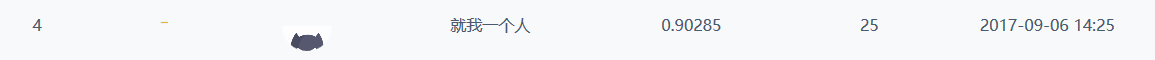<br>
<br>
为便于练习，选择如下变量：
* 月收入和年龄。收入和年龄是两个不同的scale，需要进行归一化(StandardScaler)，将一些变化幅度较大的特征化到[-1,1]之内。
* 部门。部门是分类变量，不要转化为数值变量(LabelEncode)
* EnvironmentSatisfaction。环境满意度虽然是数值型，但是属于序数，需要创建哑变量。

## 变量预处理
### 连续变量处理

In [10]:
#标准化，当变量特征化到[-1,1]
scaler = StandardScaler()
#拟合训练集的年龄
age_scale = scaler.fit(np.array(df_train['Age']).reshape(-1,1).astype(float64))
#转化训练集的年龄
df_train['Age_Scale'] = scaler.fit_transform(np.array(df_train['Age']).reshape(-1,1).astype(float64),
                                             age_scale)
#转化测试集的年龄
df_test['Age_Scale'] = scaler.fit_transform(np.array(df_test['Age']).reshape(-1,1).astype(float64),
                                            age_scale)

#对月收入进行同样的处理
income_scale = scaler.fit(np.array(df_train['MonthlyIncome']).reshape(-1,1).astype(float64))
df_train['Income_Scale'] = scaler\
                          .fit_transform(np.array(df_train['MonthlyIncome'])\
                                           .reshape(-1,1).astype(float64), income_scale)
df_test['Income_Scale'] = scaler\
                         .fit_transform(np.array(df_test['MonthlyIncome'])\
                                          .reshape(-1,1).astype(float64), income_scale)

df_train[['Age_Scale', 'Income_Scale']].head()

,Age_Scale,Income_Scale
0,0.000101,-0.104096
1,1.882064,0.852589
2,-0.332010,-0.086910
3,0.221508,1.327855
4,-0.996233,-0.824846


### 分类变量处理

In [11]:
le = LabelEncoder()

df_train['Department_Encode'] = le.fit_transform(df_train['Department'])
df_test['Department_Encode'] = le.fit_transform(df_test['Department'])

### 创建哑变量
创建哑变量有两种方式
* 使用sklearn中的OneHotEncoder
* 使用pandas中的get_dummies()

In [12]:
#使用OneHotEncoder创建哑变量
enc = OneHotEncoder()
enc_temp = enc.fit_transform(np.array(df_train['EnvironmentSatisfaction']).reshape(-1,1))\
              .toarray()
enc_temp[0:5,:]

array([[ 1.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  1.],
       [ 1.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  1.],
       [ 1.,  0.,  0.,  0.]])

从上面的结果可以看出，使用OneHotEncoder,得到的结果是array格式的，这种格式没有特征名，而且分析中其他数据都是pandas数据格式，不方便分析。

In [13]:
#使用get_dummies()
dummy = pd.get_dummies(df_train['EnvironmentSatisfaction'], prefix='EnvSat')
df_train = pd.concat([df_train, dummy], axis=1)
df_train.filter(regex='Env').head()

,EnvironmentSatisfaction,EnvSat_1,EnvSat_2,EnvSat_3,EnvSat_4
0,1,1,0,0,0
1,4,0,0,0,1
2,1,1,0,0,0
3,4,0,0,0,1
4,1,1,0,0,0


从上面的结果可以看出，用get_dummies()可以直接得到DataFrame，再用concat和数据集合并就可以。<br>
用OneHotEncoder得到的结果，需要转化为DataFrame，并且还要取名，如果特征很多，取名会相当麻烦。

In [14]:
#对测试集做相同处理
dummy = pd.get_dummies(df_test['EnvironmentSatisfaction'], prefix='EnvSat')
df_test = pd.concat([df_test, dummy], axis=1)

### 对Department_Encode创建哑变量
上面虽然对Department做了数值化，但是它和EnvironmentSatisfaction一样，需要创建哑变量

In [15]:
dummy = pd.get_dummies(df_train['Department_Encode'], prefix='DepEnc')
df_train = pd.concat([df_train, dummy], axis=1)

dummy = pd.get_dummies(df_test['Department_Encode'], prefix='DepEnc')
df_test = pd.concat([df_test, dummy], axis=1)
df_train.filter(regex='Dep').head()

,Department,Department_Encode,DepEnc_0,DepEnc_1,DepEnc_2
0,Research & Development,1,0,1,0
1,Research & Development,1,0,1,0
2,Research & Development,1,0,1,0
3,Research & Development,1,0,1,0
4,Research & Development,1,0,1,0


根据需要，也可以直接对分类变量创建哑变量

In [16]:
dummy = pd.get_dummies(df_train['Department'], prefix='Dep')
df_train = pd.concat([df_train, dummy], axis=1)

dummy = pd.get_dummies(df_test['Department'], prefix='Dep')
df_test = pd.concat([df_test, dummy], axis=1)

df_train.filter(regex='Dep').head()

,Department,Department_Encode,DepEnc_0,DepEnc_1,DepEnc_2,Dep_Human Resources,Dep_Research & Development,Dep_Sales
0,Research & Development,1,0,1,0,0,1,0
1,Research & Development,1,0,1,0,0,1,0
2,Research & Development,1,0,1,0,0,1,0
3,Research & Development,1,0,1,0,0,1,0
4,Research & Development,1,0,1,0,0,1,0


有的时候，直接对分类变量创建哑变量更方便，因为特征名是对应的特征值。当然，需要根据应用场景和分类器进行选择。

In [17]:
df_train.filter(regex='Income|Age|Dep|Env').head()

,Age,Department,EnvironmentSatisfaction,MonthlyIncome,Age_Scale,Income_Scale,Department_Encode,EnvSat_1,EnvSat_2,EnvSat_3,EnvSat_4,DepEnc_0,DepEnc_1,DepEnc_2,Dep_Human Resources,Dep_Research & Development,Dep_Sales
0,37,Research & Development,1,5993,0.000101,-0.104096,1,1,0,0,0,0,1,0,0,1,0
1,54,Research & Development,4,10502,1.882064,0.852589,1,0,0,0,1,0,1,0,0,1,0
2,34,Research & Development,1,6074,-0.332010,-0.086910,1,1,0,0,0,0,1,0,0,1,0
3,39,Research & Development,4,12742,0.221508,1.327855,1,0,0,0,1,0,1,0,0,1,0
4,28,Research & Development,1,2596,-0.996233,-0.824846,1,1,0,0,0,0,1,0,0,1,0


In [18]:
df_test.filter(regex='Income|Age|Dep|Env').head()

,Age,Department,EnvironmentSatisfaction,MonthlyIncome,Age_Scale,Income_Scale,Department_Encode,EnvSat_1,EnvSat_2,EnvSat_3,EnvSat_4,DepEnc_0,DepEnc_1,DepEnc_2,Dep_Human Resources,Dep_Research & Development,Dep_Sales
0,40,Research & Development,3,3975,0.376985,-0.541279,1,0,0,1,0,0,1,0,0,1,0
1,53,Research & Development,4,18606,1.765877,2.620823,1,0,0,0,1,0,1,0,0,1,0
2,42,Research & Development,1,6781,0.590661,0.065163,1,1,0,0,0,0,1,0,0,1,0
3,34,Human Resources,3,4490,-0.264042,-0.429976,0,0,0,1,0,1,0,0,1,0,0
4,32,Research & Development,4,2956,-0.477718,-0.761509,1,0,0,0,1,0,1,0,0,1,0


In [19]:
#提取用于训练模型的特征
X = df_train.filter(regex='_Scale|Environment|_Encode')
Y = df_train['Attrition']

In [131]:
#定义交叉验证函数
def classification_func(model, X, Y, CV=5, method=1, scoring=None):
    '''
    参数解释:
    ====================
    model: 分类器
    X: 输入的feature
    Y: 输入的target
    CV: 交叉验证次数
    method: 交叉验证的方法
            1：cross_val_score,默认
            2：cross_validate
    scoring: 评估方式,准确率/精度/召回率/F1
    '''
    #用cross_validate
    #cross_validate和cross_val_score的区别是
    #1. 可以定义多个指标
    #2. 返回一个dict
    
    if method == 'cross_validate':
        score = cross_validate(model,X,Y,scoring=scoring, cv=CV)
        print('='*60)
        for x in score.keys():
            print('the %s is %.4f'%(x,score[x].mean()))
            print('='*60)
        
    #默认用cross_val_score
    else:
        #判断是否为list
        if isinstance(scoring, list):
            print('='*60)
            for x in range(len(scoring)):
                score = cross_val_score(model, X, Y, scoring=scoring[x], cv=CV)
                print('the %s score is %.4f(+/-%.4f)'%(scoring[x], score.mean(), score.std()*2))
                print('='*60)
        #判断是否为字符串
        elif isinstance(scoring, str):
            score = cross_val_score(model, X, Y, scoring=scoring, cv=CV)
            print('the %s score is %.4f(+/-%.4f)'%(scoring, score.mean(), score.std()*2))
        #默认用准确度评估
        else:
            score = cross_val_score(model, X, Y, scoring=scoring, cv=CV)
            print('the accuracy is %.4f(+/-%.4f)'%(score.mean(),score.std()*2))

In [33]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=1, 
                        train_sizes=np.linspace(.05, 1., 20), verbose=0, ax=None):
    """
    画出data在某模型上的learning curve.
    参数解释
    ----------
    estimator : 你用的分类器。
    title : 表格的标题。
    X : 输入的feature，numpy类型
    y : 输入的target vector
    ylim : tuple格式的(ymin, ymax), 设定图像中纵坐标的最低点和最高点
    cv : 做cross-validation的时候，数据分成的份数，其中一份作为cv集，其余n-1份作为training(默认为3份)
    n_jobs : 并行的的任务数(默认1)
    """
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    if ax == None:
        plt.figure(figsize=(15,7))
        plt.title(title)
        if ylim is not None:
            plt.ylim(*ylim)
        plt.xlabel("Training examples")
        plt.ylabel("Score")
        plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
        plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1, color="g")
        plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
        plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")

        plt.legend(loc="best")
    else:
        ax.set_title(title)
        if ylim is not None:
            ax.set_ylim(*ylim)
        ax.set_xlabel("Training examples")
        ax.set_ylabel("Score")
        ax.fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
        ax.fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1, color="g")
        ax.plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
        ax.plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")

        ax.legend(loc="best")

    midpoint = ((train_scores_mean[-1] + train_scores_std[-1]) + (test_scores_mean[-1] - test_scores_std[-1])) / 2
    diff = (train_scores_mean[-1] + train_scores_std[-1]) - (test_scores_mean[-1] - test_scores_std[-1])
    return midpoint, diff

In [34]:
def plot_pr_curve(estimator, X, y,test_size=0.3, ax=None):
    """
    画出data在某模型上的P-R曲线.
    参数解释
    ----------
    estimator : 你用的分类器。
    X : 输入的feature，numpy类型
    y : 输入的target vector
    """
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y,
                                                        test_size=test_size,
                                                        random_state=0)
    estimator.fit(X_train, Y_train)
    if hasattr(estimator, 'decision_function'):
        y_score = estimator.decision_function(X_test)
    else:
        y_score = estimator.predict_proba(X_test)[:,1]
    average_precision = average_precision_score(Y_test, y_score)
    precision, recall, threshold = precision_recall_curve(Y_test, y_score)    
    
    if ax == None:
        plt.figure(figsize=(15,7))
        plt.xlabel("Recall")
        plt.ylabel("Precision")
        plt.grid()
    
        plt.step(recall, precision, color='b', alpha=0.5, where='post')
        plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
        plt.title('Precision-Recall curve: AUC={0:0.2f}'.format(average_precision))
    else:
        ax.set_xlabel("Recall")
        ax.set_ylabel("Precision")
        ax.grid()
    
        ax.step(recall, precision, color='b', alpha=0.5, where='post')
        ax.fill_between(recall, precision, step='post', alpha=0.2, color='b')
        ax.set_title('Precision-Recall curve: AUC={0:0.2f}'.format(average_precision))
    
    return

In [35]:
def plot_roc_curve(estimator, X, y, test_size=0.3, ax=None):
    """
    画出data在某模型上的ROC曲线.
    参数解释
    ----------
    estimator : 你用的分类器。
    X : 输入的feature，numpy类型
    y : 输入的target vector
    ylim : tuple格式的(ymin, ymax), 设定图像中纵坐标的最低点和最高点
    cv : 做cross-validation的时候，数据分成的份数，其中一份作为cv集，其余n-1份作为training(默认为3份)
    n_jobs : 并行的的任务数(默认1)
    """
    
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y,
                                                        test_size=test_size,
                                                        random_state=0)
    estimator.fit(X_train, Y_train)
    if hasattr(estimator, 'decision_function'):
        y_score = estimator.decision_function(X_test)
    else:
        y_score = estimator.predict_proba(X_test)[:,1]
    roc_score = roc_auc_score(Y_test, y_score)
    fpr, tpr, threshold = roc_curve(Y_test, y_score)
    #roc_score = auc(fpr, tpr)
    
    if ax == None:
        plt.figure(figsize=(15,7))
        plt.xlabel("Recall")
        plt.ylabel("Precision")
        plt.grid()
    
        plt.step(fpr, tpr, color='b', alpha=0.5, where='post')
        plt.fill_between(fpr, tpr, step='post', alpha=0.2, color='b')
        #plt.ylim([0.0, 1.05])
        #plt.xlim([0.0, 1.0])
        plt.title('ROC curve: AUC={0:0.2f}'.format(roc_score))
    else:
        ax.set_xlabel("Recall")
        ax.set_ylabel("Precision")
        ax.grid()
    
        ax.step(fpr, tpr, color='b', alpha=0.5, where='post')
        ax.fill_between(fpr, tpr, step='post', alpha=0.2, color='b')
        #plt.ylim([0.0, 1.05])
        #plt.xlim([0.0, 1.0])
        ax.set_title('ROC curve: AUC={0:0.2f}'.format(roc_score))
    
    return

In [40]:
classifiers = {'Logistic Regression': LogisticRegression(),
               'Random Forest': RandomForestClassifier()}
for label, clf in classifiers.items():
    print('\nthe result of %s'%label)
    classification_func(clf,X,Y)


the result of Logistic Regression
the accuracy is 0.8382(+/-0.0033)

the result of Random Forest
the accuracy is 0.8128(+/-0.0334)


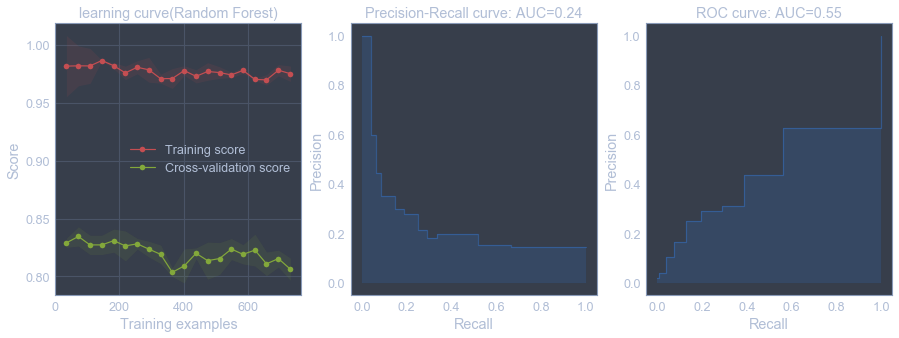

In [39]:
#分别绘制学习曲线，PR曲线和ROC曲线
fig, ax = plt.subplots(1,3,figsize=(15,5))
plot_learning_curve(clf,'learning curve(Random Forest)', X,Y,ax=ax[0])
plot_pr_curve(clf, X,Y,ax=ax[1])
plot_roc_curve(clf, X,Y,ax=ax[2])

## 自动化调参

[sklearn.model_selection.GridSearchCV](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html#sklearn.model_selection.GridSearchCV)会根据设定好的参数范围，利用交叉验证，自动化搜索最好的参数。

In [104]:
def report(results, n_top=3):
    #n_top是要输出的最好的参数个数，默认是前3个最好的参数
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))

            
def grid_search(clf, param_grid, X, Y,
                verbose=0, test_size=0.2, cv=3, random_state=None):
    
    # 生成训练集和验证集
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y,
                                                        test_size=test_size,
                                                        random_state=random_state)
    
    #使用grid_search找到最好的参数
    param_grid = param_grid
    
    # run grid search
    grid_search = GridSearchCV(clf, param_grid=param_grid, verbose=verbose)
    start = time.time()
    grid_search.fit(X_train, Y_train)
    print("\nBest score: %0.3f" % grid_search.best_score_)
    print('='*90)
    print(grid_search.best_estimator_)
    print('='*90)
    print("GridSearchCV took %.2f seconds for %d candidate parameter settings."
          % (time.time() - start, len(grid_search.cv_results_['params'])))
    print('='*90)
    report(grid_search.cv_results_)
    print('='*40+'参数搜索结束'+'='*40)
    
    print('交叉验证')
    print('训练集')
    score = cross_val_score(grid_search.best_estimator_, X_train, Y_train, cv=cv)
    print(score.mean(), score)
    print('验证集')
    score = cross_val_score(grid_search.best_estimator_, X_test, Y_test, cv=cv)
    print(score.mean(), score)
    print('='*90)
    print('混淆矩阵')
    print(confusion_matrix(Y_test,
                           grid_search.best_estimator_.predict(X_test)))
    print('='*90)
    print('验证报告')
    print(classification_report(Y_test,
                                grid_search.best_estimator_.predict(X_test)))
    return grid_search.best_estimator_

In [105]:
# 对LogisticRegression进行自动化调参
param_grid = {"tol": np.logspace(-6,-3,4),
                  "C": np.logspace(-2,1,4),
                  "penalty": ['l1','l2']}
clf = grid_search(lr, param_grid, X, Y)


Best score: 0.833
LogisticRegression(C=0.10000000000000001, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=9.9999999999999995e-07, verbose=0,
          warm_start=False)
GridSearchCV took 0.55 seconds for 32 candidate parameter settings.
Model with rank: 1
Mean validation score: 0.833 (std: 0.003)
Parameters: {'C': 0.10000000000000001, 'penalty': 'l2', 'tol': 9.9999999999999995e-07}
Model with rank: 1
Mean validation score: 0.833 (std: 0.003)
Parameters: {'C': 0.10000000000000001, 'penalty': 'l2', 'tol': 1.0000000000000001e-05}
Model with rank: 1
Mean validation score: 0.833 (std: 0.003)
Parameters: {'C': 0.10000000000000001, 'penalty': 'l2', 'tol': 0.0001}
Model with rank: 1
Mean validation score: 0.833 (std: 0.003)
Parameters: {'C': 0.10000000000000001, 'penalty': 'l2', 'tol': 0.001}
Model with rank: 1
Mean validation score: 0.833

C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


虽然准确度是83%，但是从混淆矩阵可以看出，所有的预测结果均为0，才会导致召回率为1（0为正例），而在验证报告中，如果正例为1，精度和召回率全部为0。

In [109]:
# 对RandomForestClassifier进行自动化调参
param_grid = {"n_estimators": range(10,51,5),
              "max_depth": range(5,11),
              "max_features":range(2,5)}
rf = RandomForestClassifier()
best_rf = grid_search(rf, param_grid, X, Y)


Best score: 0.849
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features=4, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=35, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
GridSearchCV took 52.99 seconds for 162 candidate parameter settings.
Model with rank: 1
Mean validation score: 0.849 (std: 0.010)
Parameters: {'max_depth': 5, 'max_features': 4, 'n_estimators': 35}
Model with rank: 2
Mean validation score: 0.848 (std: 0.009)
Parameters: {'max_depth': 5, 'max_features': 2, 'n_estimators': 20}
Model with rank: 2
Mean validation score: 0.848 (std: 0.009)
Parameters: {'max_depth': 5, 'max_features': 2, 'n_estimators': 25}
Model with rank: 2
Mean validation score: 0.848 (std: 0.011)
Parameters: {'max_depth': 5, 'max_features': 3, 'n

对于Random Forest而言，预测准确率比前面好一点，原因是没有把所有的结果判为0，而是有4个样本判断为1。

## Bagging方法
Bagging是对训练集做有返回抽样，随机生成n个子集，分别进行训练，将n个分类器得到的结果集成为最终结果。其中分类器和子集的个数与参数n_estimator相等。

In [137]:
 clf = BaggingClassifier(base_estimator=best_rf, n_estimators=5,
                        max_samples=0.8, max_features=1.0,
                        bootstrap=True, bootstrap_features=False)

classification_func(clf, X, Y)

the accuracy is 0.8400(+/-0.0078)


## 参考文献

* [机器学习系列(3)_逻辑回归应用之Kaggle泰坦尼克之灾](http://blog.csdn.net/han_xiaoyang/article/details/49797143)
* scikit learn官方文档-[4.3. Preprocessing data](http://scikit-learn.org/stable/modules/preprocessing.html#preprocessing)
* scikit learn官方文档-[3.3. Model evaluation: quantifying the quality of predictions](http://scikit-learn.org/stable/modules/model_evaluation.html)
* scikit learn官方文档-[3.1. Cross-validation: evaluating estimator performance](http://scikit-learn.org/stable/modules/cross_validation.html)
* scikit learn官方文档-[3.5. Validation curves: plotting scores to evaluate models](http://scikit-learn.org/stable/modules/learning_curve.html)
* scikit learn官方文档-[1.11 Ensemble methods](http://scikit-learn.org/stable/modules/ensemble.html#bagging)
* 《机器学习》，周志华，清华大学出版社
* 《机器学习实战》，Peter Harrington，人民邮电出版社
* 《集体智慧编程》，Toby Segaran，电子工业出版社
